In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [130]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

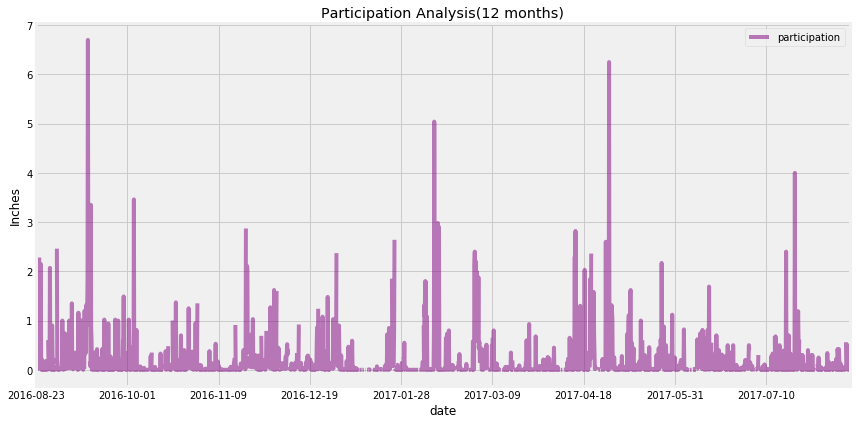

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
last_year = dt.date(2017,8,23) - dt.timedelta(days = 365)
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(query, columns = ['date','participation'])
# Sort the dataframe by date
results_df.set_index('date', inplace = True)
results_df = results_df.sort_values(by = 'date', ascending = True)
# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(title="Participation Analysis(12 months)",color = 'purple', figsize =(12,6), alpha = 0.5)
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,participation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?
station_num= session.query(Station).count()
print (f"There are {station_num} stations available.")

There are 9 stations available.


In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"The most active stations are:")
active_station

The most active stations are:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [106]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_station[0][0]

lowesttemp = (session.query(Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs.asc()).first())
lowesttemp = lowesttemp[0]

highesttemp = (session.query(Measurement.tobs).filter(Measurement.station == most_active_station).order_by(Measurement.tobs.desc()).first())
highesttemp = highesttemp[0]

avgtemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station))
avgtemp = '{0:.3}'.format(avgtemp[0][0])

print(f"The most active station is : {most_active_station}.")
print(f"The lowest temperature recorded there is {lowesttemp} degrees.")
print(f"The highest temperature recorded there is {highesttemp} degrees.")
print(f"The average temperature recorded there is {avgtemp} degrees.")


The most active station is : USC00519281.
The lowest temperature recorded there is 54.0 degrees.
The highest temperature recorded there is 85.0 degrees.
The average temperature recorded there is 71.7 degrees.


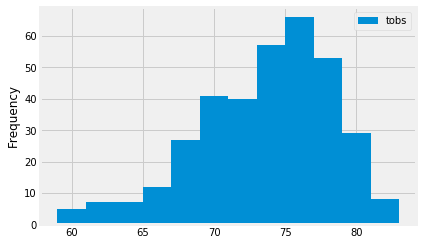

In [108]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query2 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= last_year).all()

df1 = pd.DataFrame(query2, columns=['tobs'])

df1.plot.hist(bins=12)

## Bonus Challenge Assignment

In [109]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [114]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin_tavg_tmax = calc_temps('2016-08-23', '2016-10-01')
print(tmin_tavg_tmax)

[(71.0, 78.3490909090909, 86.0)]


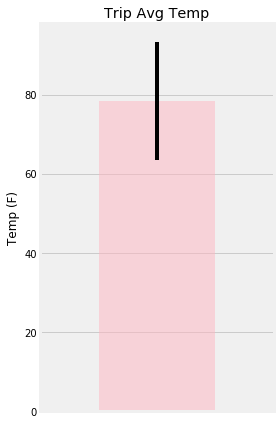

In [117]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(tmin_tavg_tmax, columns=['tmin', 'tavg', 'tmax'])

trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='lightpink', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [120]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= '2016-08-23').\
                    filter(Measurement.date <= '2016-10-01').\
                    group_by(Measurement.station).\
                    order_by(Measurement.prcp.desc()).all()
print(rainfall_per_station)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [126]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [147]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-08-23'
end_date ='2016-10-01'



In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
